<a href="https://colab.research.google.com/github/Garik-ctrl/AIRemoteZ8028/blob/main/2025_03_22_AIEngineer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1) Načti data z Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('train.csv')

In [ ]:
df.info()

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2) zobrazení počtu chybějících hodnot pro jednotlivé proměnné

In [4]:
missing=df.isnull().sum() # načtení sumy prázdných hodnot

In [5]:
missing=missing[missing>0].sort_values(ascending=False)
missing

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageType,81
GarageYrBlt,81
GarageFinish,81


## 3) doplnění chybějících hodnot

In [6]:
num_missing=missing.index[df[missing.index].dtypes!='object']
num_missing # vytvoření pole, ve kterém budu mít sloupce k doplnění

Index(['LotFrontage', 'GarageYrBlt', 'MasVnrArea'], dtype='object')

In [7]:
from sklearn.impute import SimpleImputer, KNNImputer

### a) median

In [8]:
imputer_median=SimpleImputer(strategy='median')
df_median=df.copy()
df_median[num_missing]=imputer_median.fit_transform(df_median[num_missing])

### b) průměr

In [9]:
imputer_mean=SimpleImputer(strategy='mean')
df_mean=df.copy()
df_mean[num_missing]=imputer_mean.fit_transform(df_mean[num_missing])

### c) KNN, k=5

In [10]:
imputer_KNN5=KNNImputer(n_neighbors=5)
df_KNN5=df.copy()
df_KNN5[num_missing]=imputer_KNN5.fit_transform(df_KNN5[num_missing])

## 4) Porovnání metod pomocí density grafu

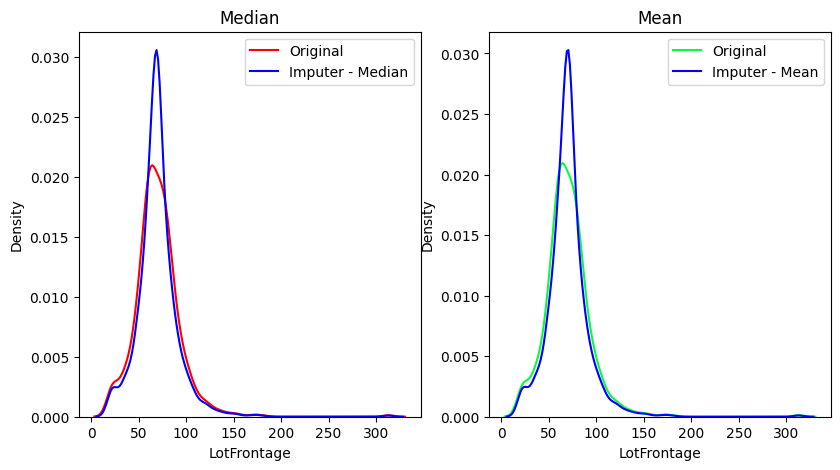

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.kdeplot(df[num_missing[0]], color='r', label='Original')
sns.kdeplot(df_median[num_missing[0]], color='b', label='Imputer - Median')
plt.title('Median')
plt.legend()

plt.subplot(1,3,2)
sns.kdeplot(df[num_missing[0]], color='#0cf93e', label='Original')
sns.kdeplot(df_mean[num_missing[0]], color='b', label='Imputer - Mean')
plt.title('Mean')
plt.legend()


## 5) normalizace číselných proměnných

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

### 5a) Standard

In [13]:
selected=['LotFrontage', 'GarageYrBlt', 'MasVnrArea']

scaler_std=StandardScaler()
df_std=df_KNN5.copy()
df_std[selected]=scaler_std.fit_transform(df_std[selected])

### b) MinMax

In [14]:
scaler_minmax=MinMaxScaler() # používáme minamax
df_minmax=df_KNN5.copy()
df_minmax[selected]=scaler_minmax.fit_transform(df_minmax[selected])

### c) Robust

In [15]:
scaler_robust=RobustScaler() # používáme minamax
df_robust=df_KNN5.copy()
df_robust[selected]=scaler_robust.fit_transform(df_robust[selected])

## 6) porovnání jednotlivých metod pomocí boxplotu

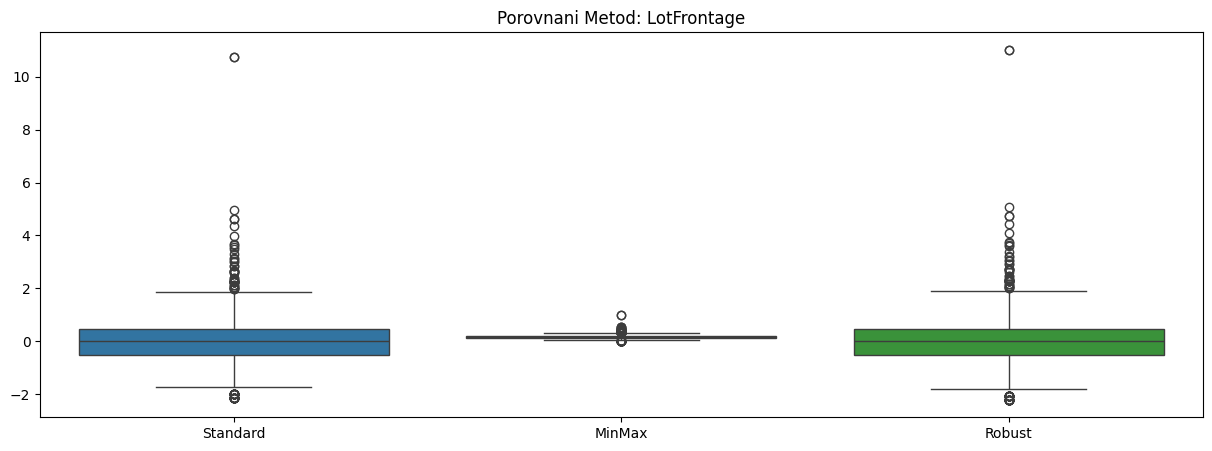

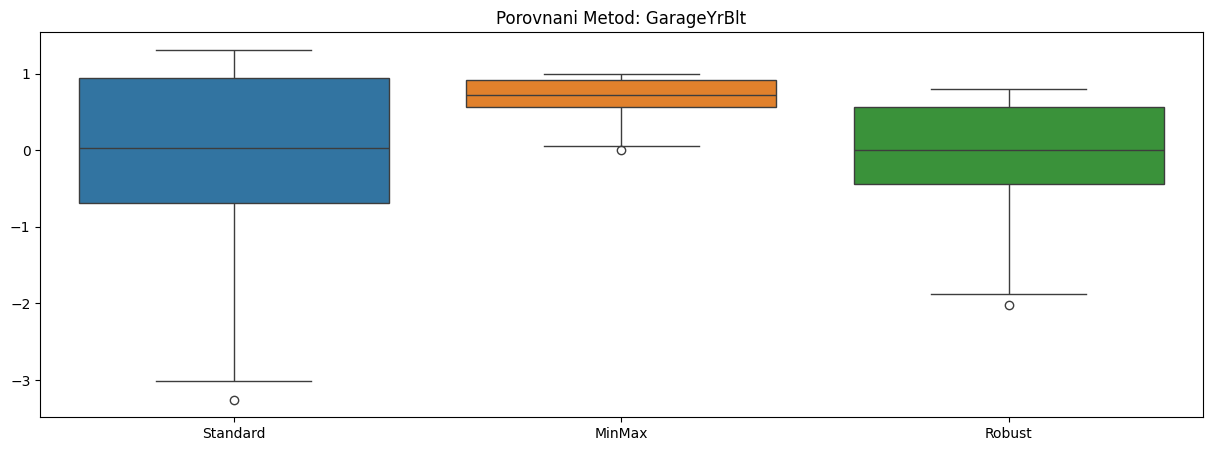

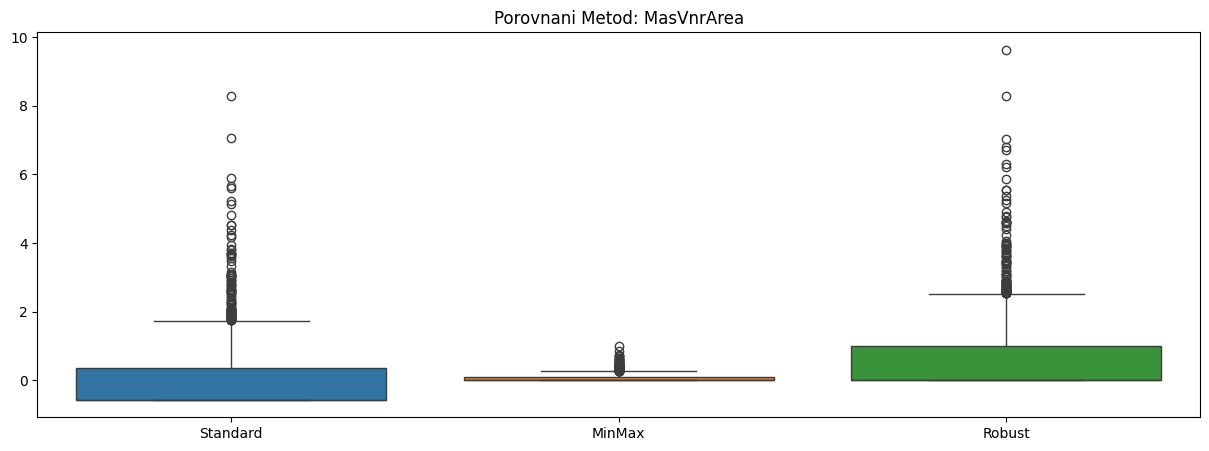

In [16]:
for col in selected:
  plt.figure(figsize=(15,5))
  sns.boxplot(data=pd.DataFrame({
      'Standard': df_std[col],
      'MinMax': df_minmax[col],
      'Robust': df_robust[col]}))
  plt.title(f'Porovnani Metod: {col}')
  plt.show()

## 6) korelační matice

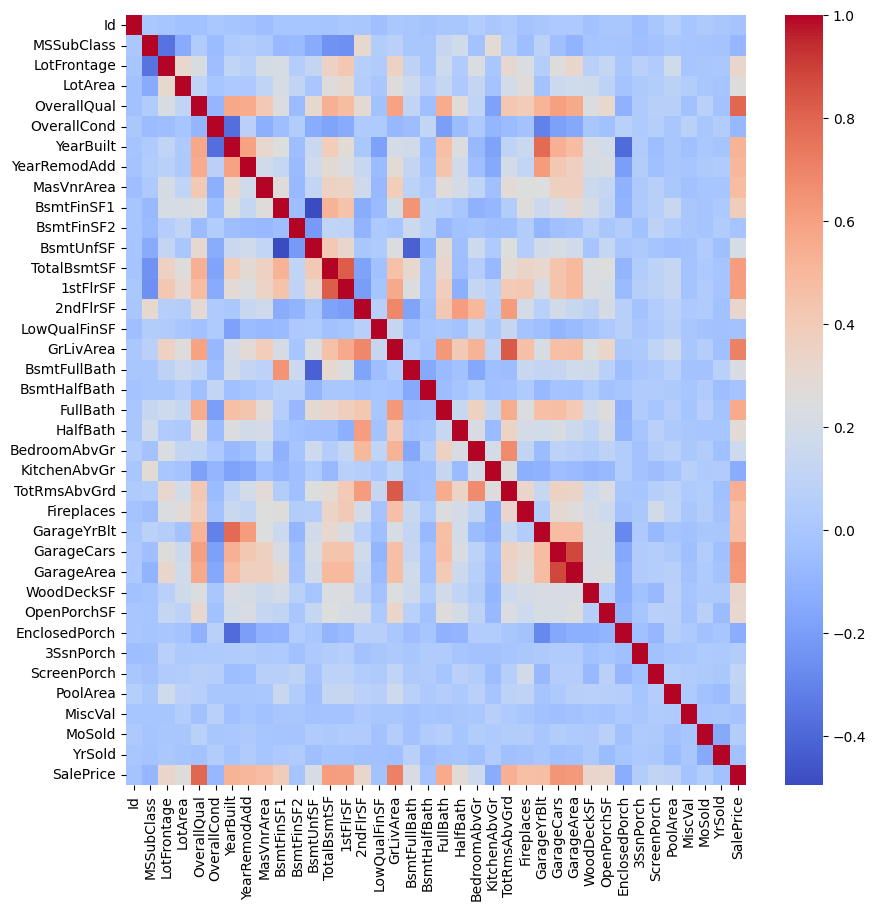

In [55]:
corr_matrix=df_std.select_dtypes(include=np.number).corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, cmap='coolwarm',annot=False)
plt.show()

In [56]:
threshold=0.8
corr_pairs=corr_matrix.abs().unstack().sort_values(ascending=False)
corr_pairs=corr_pairs[(corr_pairs!=1) & (corr_pairs>threshold)]
corr_pairs

,,0
GarageArea,GarageCars,0.882475
GarageCars,GarageArea,0.882475
TotRmsAbvGrd,GrLivArea,0.825489
GrLivArea,TotRmsAbvGrd,0.825489
1stFlrSF,TotalBsmtSF,0.819530
TotalBsmtSF,1stFlrSF,0.819530


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [57]:
X=df_KNN5.select_dtypes(include=np.number).drop('SalePrice', axis=1)
Y=df_KNN5['SalePrice']

In [58]:
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.2, random_state=42)

In [59]:
model=LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [60]:
y_pred=model.predict(X_test)
mse=mean_squared_error(Y_test, y_pred)
r2=r2_score(Y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 1351226063.41
R-squared: 0.82


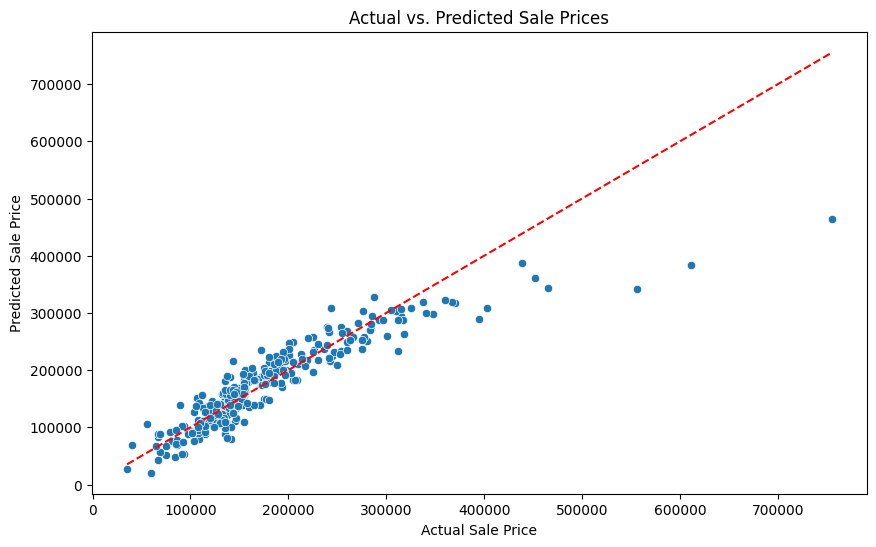

In [61]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=Y_test, y=y_pred)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], linestyle='--', color='red')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs. Predicted Sale Prices')
plt.show()

In [46]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [48]:
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, Y_train)
y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(Y_test, y_pred_rf)
r2_rf = r2_score(Y_test, y_pred_rf)

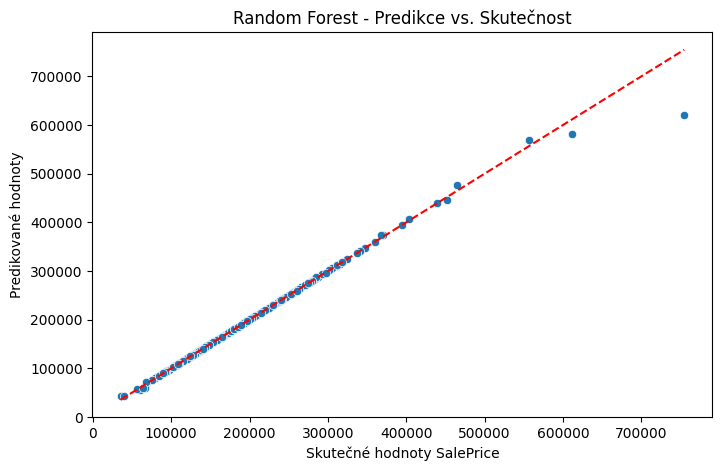

In [50]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=Y_test, y=y_pred_rf)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--r')
plt.xlabel("Skutečné hodnoty SalePrice")
plt.ylabel("Predikované hodnoty")
plt.title("Random Forest - Predikce vs. Skutečnost")
plt.show()

In [62]:
from sklearn.ensemble import GradientBoostingRegressor

In [66]:
model_GB = GradientBoostingRegressor()
model_GB.fit(X_train, Y_train)  # Trénink modelu
y_pred=model_GB.predict(X_test)
mse=mean_squared_error(Y_test, y_pred)
r2=r2_score(Y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 835883109.17
R-squared: 0.89


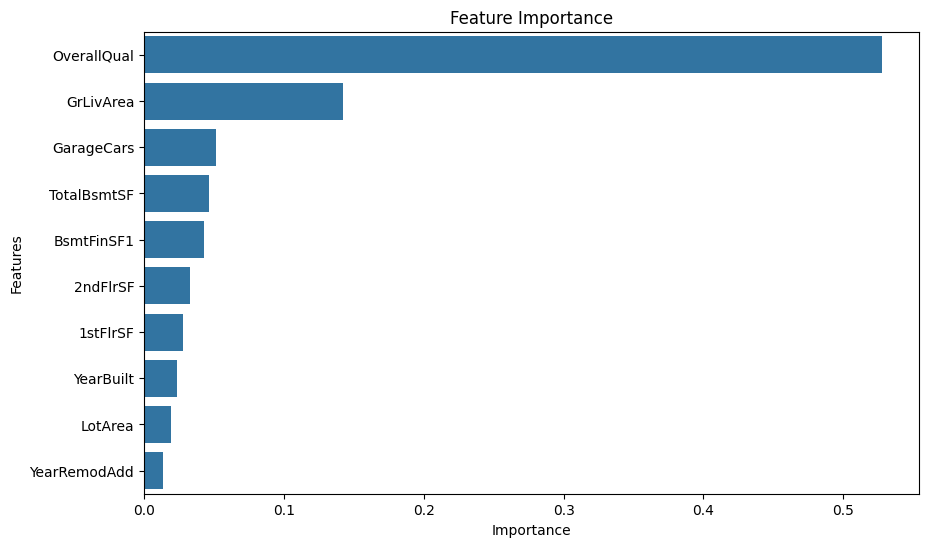

In [67]:
important_features = pd.Series(model_GB.feature_importances_, index=X.columns)
important_features=important_features.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=important_features, y=important_features.index)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

In [69]:
important_features

,0
OverallQual,0.527749
GrLivArea,0.142389
GarageCars,0.051373
TotalBsmtSF,0.046803
BsmtFinSF1,0.043028
2ndFlrSF,0.033218
1stFlrSF,0.027840
YearBuilt,0.023504
LotArea,0.019605
YearRemodAdd,0.013879


In [70]:
X=df_KNN5[important_features.index]
Y=df_KNN5['SalePrice']

In [72]:
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.2, random_state=42)

In [73]:
model_GB = GradientBoostingRegressor()
model_GB.fit(X_train, Y_train)  # Trénink modelu
y_pred=model_GB.predict(X_test)
mse=mean_squared_error(Y_test, y_pred)
r2=r2_score(Y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 891422030.83
R-squared: 0.88


## Module Summary

In [74]:
import pandas as pd

In [75]:
df=pd.read_csv('dengue.csv')

In [83]:
df.head(20)

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,stations,cases,labels
0,34.053151,24.478082,28.709863,39.757808,25.317808,32.306301,22.971233,73.508219,2.921726,44.657534,...,1007.911781,50.747945,3.789863,208.097808,17.973699,7.232877,2.558904,1.197260,4925.0,normal
1,34.086179,25.694309,29.464228,41.338211,28.140650,34.423577,23.484553,72.066667,3.783415,39.837398,...,1003.533333,48.313821,2.884553,222.926016,19.246341,7.504065,1.658537,0.991870,5077.0,normal
2,34.573984,25.417886,29.526829,40.464228,26.560163,33.085366,22.580488,69.424390,3.065854,33.333333,...,1005.731707,55.621138,4.242276,229.413008,19.802439,7.829268,1.910569,1.170732,7579.0,normal
3,33.020325,25.080488,28.727642,37.878049,26.193496,31.772358,21.752033,69.297561,6.025203,37.398374,...,1003.359350,50.208130,2.991057,225.421951,19.480488,7.593496,1.300813,0.146341,13706.0,normal
4,30.660976,24.230894,26.774797,36.586992,24.263415,28.943902,24.214634,86.652033,23.336585,96.747967,...,1009.995935,45.542276,3.886992,176.598374,15.261789,6.186992,0.967480,3.951220,82.0,normal
5,28.279675,20.695122,23.818699,29.506504,20.695122,24.056098,19.927642,80.494309,4.219911,85.365854,...,0.000000,59.769919,7.062602,195.847967,16.925203,7.008130,0.853659,0.983740,9669.0,normal
6,32.060163,25.723577,28.496748,38.978049,27.621951,33.214634,24.824390,81.698374,6.349325,46.341463,...,1003.519512,57.928455,3.264228,196.900000,17.007317,6.788618,1.447154,0.000000,6772.0,normal
7,34.237398,26.526016,29.847967,41.382114,28.377236,34.901626,24.558537,74.819512,8.959569,54.471545,...,1008.212195,56.070732,6.056098,169.027642,14.573171,5.967480,0.544715,1.869919,10342.0,normal
8,34.460976,23.867480,28.787805,39.463415,24.445528,32.002439,21.492683,67.514634,4.517886,61.788618,...,1003.942276,29.597561,2.595122,238.502439,20.600813,7.731707,1.756098,1.000000,12542.0,normal
9,30.769106,23.066667,26.313821,36.357724,23.066667,28.114634,24.065854,88.390244,11.597561,91.869919,...,1010.143089,78.597561,3.722764,208.988618,18.047967,7.382114,2.422764,0.764228,150.0,normal


In [77]:
df=df.drop(columns=["serial"])

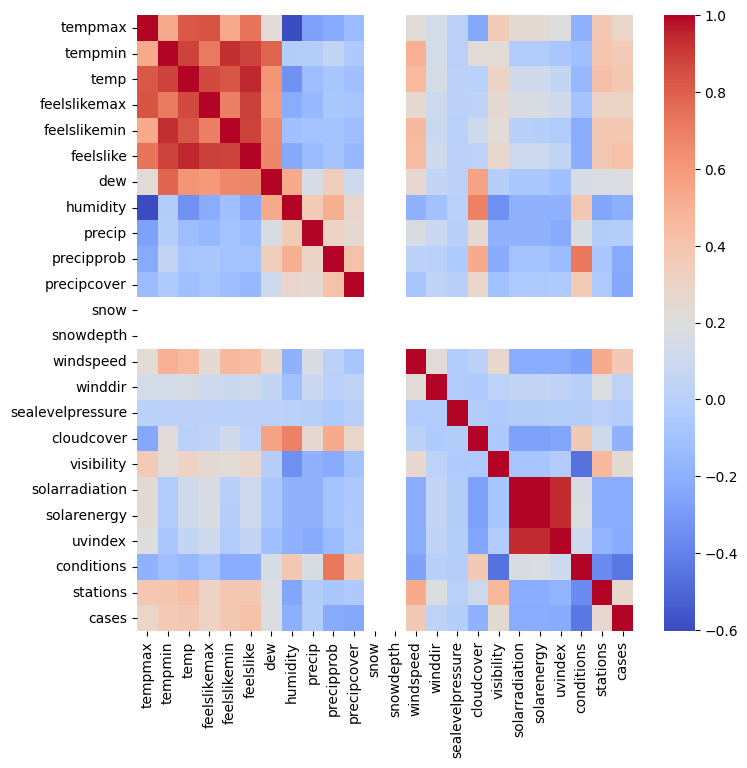

solarenergy     solarradiation    0.999770
solarradiation  solarenergy       0.999770
temp            feelslike         0.949866
feelslike       temp              0.949866
solarradiation  uvindex           0.943408
uvindex         solarradiation    0.943408
                solarenergy       0.942740
solarenergy     uvindex           0.942740
tempmin         feelslikemin      0.931412
feelslikemin    tempmin           0.931412
feelslike       feelslikemax      0.891305
feelslikemax    feelslike         0.891305
feelslike       feelslikemin      0.883670
feelslikemin    feelslike         0.883670
feelslike       tempmin           0.883030
tempmin         feelslike         0.883030
                temp              0.881988
temp            tempmin           0.881988
feelslikemax    temp              0.863626
temp            feelslikemax      0.863626
feelslikemax    tempmax           0.832811
tempmax         feelslikemax      0.832811
feelslikemin    temp              0.829122
temp            feelslikemin      0.829122
                tempmax           0.820941
tempmax         temp              0.820941
dtype: float64

In [86]:
correlation_matrix=df.corr(numeric_only=True)
plt.figure(figsize=(8,8))
sns.heatmap(correlation_matrix, cmap='coolwarm',annot=False)
plt.show()
threshold=0.8
corr_pairs=correlation_matrix.abs().unstack().sort_values(ascending=False)
corr_pairs=corr_pairs[(corr_pairs!=1) & (corr_pairs>threshold)]
corr_pairs

In [89]:
df_Cleaned=df.drop(columns=["snow", "snowdepth","solarradiation","tempmin","tempmax","feelslikemin","feelslikemax","feelslike","uvindex"])

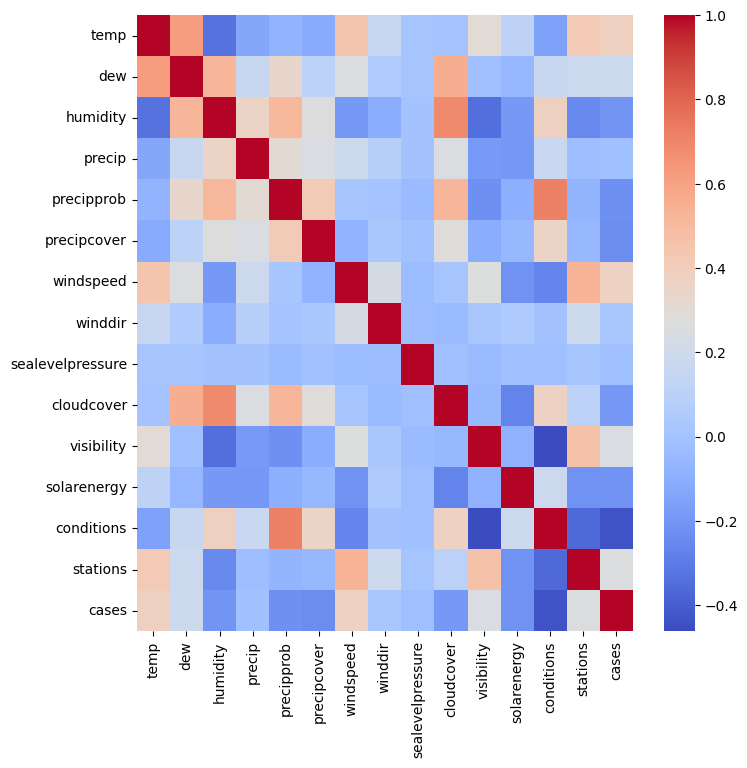

,,0


In [90]:
correlation_matrix=df_Cleaned.corr(numeric_only=True)
plt.figure(figsize=(8,8))
sns.heatmap(correlation_matrix, cmap='coolwarm',annot=False)
plt.show()
threshold=0.8
corr_pairs=correlation_matrix.abs().unstack().sort_values(ascending=False)
corr_pairs=corr_pairs[(corr_pairs!=1) & (corr_pairs>threshold)]
corr_pairs

In [93]:
df_Cleaned.head(20)

,temp,dew,humidity,precip,precipprob,precipcover,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarenergy,conditions,stations,cases,labels
0,28.709863,22.971233,73.508219,2.921726,44.657534,4.360932,15.678356,175.595342,1007.911781,50.747945,3.789863,17.973699,2.558904,1.197260,4925.0,normal
1,29.464228,23.484553,72.066667,3.783415,39.837398,2.676748,14.574797,158.349593,1003.533333,48.313821,2.884553,19.246341,1.658537,0.991870,5077.0,normal
2,29.526829,22.580488,69.424390,3.065854,33.333333,2.337805,14.978049,202.621138,1005.731707,55.621138,4.242276,19.802439,1.910569,1.170732,7579.0,normal
3,28.727642,21.752033,69.297561,6.025203,37.398374,2.676667,16.504878,183.544715,1003.359350,50.208130,2.991057,19.480488,1.300813,0.146341,13706.0,normal
4,26.774797,24.214634,86.652033,23.336585,96.747967,15.616992,19.546341,224.030081,1009.995935,45.542276,3.886992,15.261789,0.967480,3.951220,82.0,normal
5,23.818699,19.927642,80.494309,4.219911,85.365854,9.891789,22.116260,225.817073,0.000000,59.769919,7.062602,16.925203,0.853659,0.983740,9669.0,normal
6,28.496748,24.824390,81.698374,6.349325,46.341463,3.896098,15.234146,147.413008,1003.519512,57.928455,3.264228,17.007317,1.447154,0.000000,6772.0,normal
7,29.847967,24.558537,74.819512,8.959569,54.471545,4.810732,25.482114,210.036585,1008.212195,56.070732,6.056098,14.573171,0.544715,1.869919,10342.0,normal
8,28.787805,21.492683,67.514634,4.517886,61.788618,25.677642,12.895122,149.186992,1003.942276,29.597561,2.595122,20.600813,1.756098,1.000000,12542.0,normal
9,26.313821,24.065854,88.390244,11.597561,91.869919,17.312439,10.093496,169.942276,1010.143089,78.597561,3.722764,18.047967,2.422764,0.764228,150.0,normal


In [94]:
df_Cleaned=df_Cleaned.round(2)

In [95]:
df_Cleaned.head()

,temp,dew,humidity,precip,precipprob,precipcover,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarenergy,conditions,stations,cases,labels
0,28.71,22.97,73.51,2.92,44.66,4.36,15.68,175.60,1007.91,50.75,3.79,17.97,2.56,1.20,4925.0,normal
1,29.46,23.48,72.07,3.78,39.84,2.68,14.57,158.35,1003.53,48.31,2.88,19.25,1.66,0.99,5077.0,normal
2,29.53,22.58,69.42,3.07,33.33,2.34,14.98,202.62,1005.73,55.62,4.24,19.80,1.91,1.17,7579.0,normal
3,28.73,21.75,69.30,6.03,37.40,2.68,16.50,183.54,1003.36,50.21,2.99,19.48,1.30,0.15,13706.0,normal
4,26.77,24.21,86.65,23.34,96.75,15.62,19.55,224.03,1010.00,45.54,3.89,15.26,0.97,3.95,82.0,normal
